# Classification 1

The topics in learning unit 3 on classification are quite diverse and some are highly theoretical. Below you will find some practical exercises to help you with these various topics.

The following topics will be addressed:
- Probably approximately correct learning
- One-vs-all vs one-vs-one
- The bias/variance trade-off
- Model, loss-function, optimizer (only briefly)
- The Mahalanobis distance (which uses the covariance matrix)
- Linear regression
- Logistic regression

The Vapnik-Chervonenkis dimension is mostly of theoretical interest. Cross-validation is part of the notebook for learning unit 5.

# Chicago face database

In this notebook, we will work with data from the Chicago face database (https://www.chicagofaces.org/). This database contains facial images of people from four different races (black, white, Latino, Asian).

For each face, there are also:
* Ratings by others of perceived features, such as trustworthiness
* Demographic information, such as age
* Measurements of facial features, such as the height of the chin
    
We start with loading the data.

In [18]:
path = "/home/frouke/Documents/OU/MachineLearning/Classification/" #replace with your own path
import pandas as pd

faces = pd.read_csv(path + "chicagoRatings.csv")
print(faces.columns) #show the names of the columns
faces.head()

Index(['Target', 'Race', 'Gender', 'Age', 'NumberofRaters', 'Female_prop',
       'Male_prop', 'Asian_prop', 'Black_prop', 'Latino_prop', 'Multi_prop',
       'Other_prop', 'White_prop', 'Afraid', 'Angry', 'Attractive', 'Babyface',
       'Disgusted', 'Dominant', 'Feminine', 'Happy', 'Masculine', 'Prototypic',
       'Sad', 'Suitability', 'Surprised', 'Threatening', 'Trustworthy',
       'Unusual', 'Luminance_median', 'Nose_Width', 'Nose_Length',
       'Lip_Thickness', 'Face_Length', 'R_Eye_H', 'L_Eye_H', 'Avg_Eye_Height',
       'R_Eye_W', 'L_Eye_W', 'Avg_Eye_Width', 'Face_Width_Cheeks',
       'Face_Width_Mouth', 'Forehead', 'Pupil_Top_R', 'Pupil_Top_L',
       'Asymmetry_pupil_top', 'Pupil_Lip_R', 'Pupil_Lip_L',
       'Asymmetry_pupil_lip', 'BottomLip_Chin', 'Midcheek_Chin_R',
       'Midcheek_Chin_L', 'Cheeks_avg', 'Midbrow_Hairline_R',
       'Midbrow_Hairline_L', 'Faceshape', 'Heartshapeness', 'Noseshape',
       'LipFullness', 'EyeShape', 'EyeSize', 'UpperHeadLength',
       '

,Target,Race,Gender,Age,NumberofRaters,Female_prop,Male_prop,Asian_prop,Black_prop,Latino_prop,...,EyeShape,EyeSize,UpperHeadLength,MidfaceLength,ChinLength,ForeheadHeight,CheekboneHeight,CheekboneProminence,FaceRoundness,fWHR
0,AF-200,A,F,32.571429,28,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.404651,0.060924,0.414099,0.326797,0.130719,0.264706,0.388189,91.5,0.545752,1.921146
1,AF-201,A,F,23.666667,27,1.000000,0.000000,0.962963,0.000000,0.000000,...,0.329204,0.041892,0.414414,0.329279,0.144595,0.300901,0.383784,146.0,0.488288,1.901129
2,AF-202,A,F,24.448276,29,0.827586,0.172414,0.310345,0.068966,0.137931,...,0.357939,0.051586,0.411080,0.310317,0.173424,0.298475,0.397029,58.0,0.481333,1.888249
3,AF-203,A,F,22.758621,29,1.000000,0.000000,0.758621,0.000000,0.068966,...,0.443200,0.063913,0.354407,0.343793,0.169820,0.272266,0.421089,87.5,0.500231,1.863719
4,AF-204,A,F,30.137931,29,1.000000,0.000000,0.827586,0.000000,0.068966,...,0.432247,0.053435,0.438931,0.293045,0.180237,0.293893,0.371925,73.5,0.513571,1.935783


# Probably approximately correct (PAC) learning

This section makes use of: https://medium.com/@jodhernandezbemj/understanding-pac-learning-an-introduction-with-python-examples-72d57c38c9b4

PAC learning is a theoretical framework to determine whether a certain prediction task is learnable (“approximately correct”).

Three parameters are used:
- n: the number of samples used for training
- epsilon: the acceptable error level
- delta: the confidence level
    
A higher n makes it more likely that the problem is learnable. Lower values of epsilon and delta place higher demands on what we decide is "learnable".

Whether something is learnable is controlled by Hoeffding’s inequality:

![alt text](inequality.png "Hoeffding’s inequality")

There is no delta in this equation yet. The term on the right can be renamed to delta, so that you get:

![alt text](inequality2.png "Hoeffding’s inequality expressed with delta")

E(h) in these equations is the error or misclassification rate on unseen data (the test set). E(h^d) is the error or misclassification rate h on the training data (the empirical error). 

To use the inequality, we consider the task of predicting the race of a face (Black or White) from the facial features: 'Nose_Width', 'Nose_Length','Lip_Thickness' and 'Face_Length'.

We start with selecting the required rows and columsn from our data-frame.

In [19]:
for_PAC = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
for_PAC = for_PAC[(for_PAC["Race"] == "B") | (for_PAC["Race"] == "W")]
for_PAC.head()

,Race,Nose_Width,Nose_Length,Lip_Thickness,Face_Length
109,B,238.5,230.5,150.0,1085.5
110,B,238.5,247.0,145.5,1016.0
111,B,229.5,232.5,105.5,1078.5
112,B,241.0,208.0,157.0,1118.5
113,B,257.5,248.0,150.0,1120.0


We first use Seaborn's pairplot to get a sense of how well these variables predict race. It seems that nose width and lip thickness are good predictors.

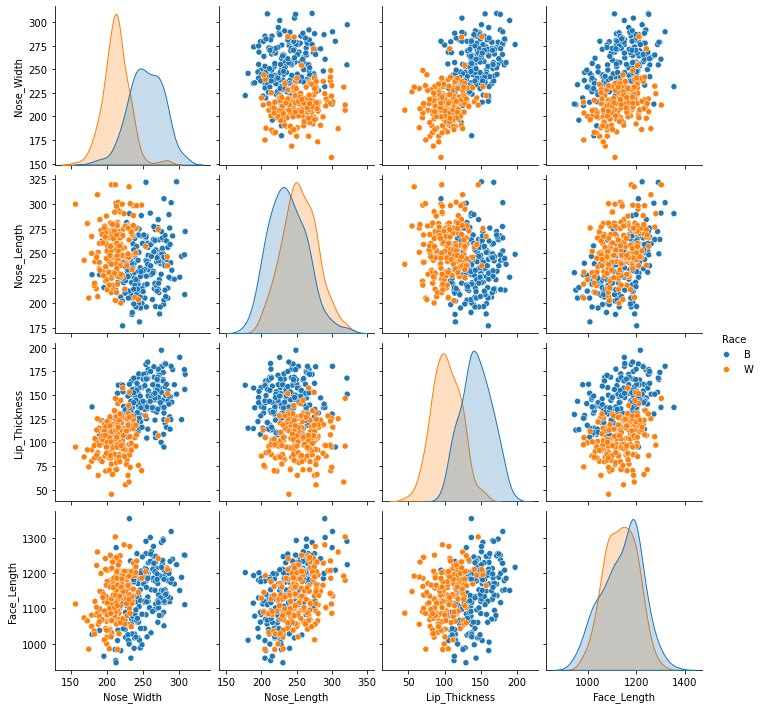

In [20]:
import seaborn as sns

sns.pairplot(for_PAC, hue="Race")

We split the data into training and test and apply the inequality to see whether the problem is learnable with the given training set size (n). Note that sklearn has a procedure to do this split for you (so no need to program it).

The result will depend on the model that is used. We will use the logistic regression here. For now, just treat this classifier as a black box. In go the nose length, the lip thickness, the nose width, and face length and out goes the predicted race.

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np

X = for_PAC[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_PAC["Race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

model = LogisticRegression()
model.fit(X_train, y_train)
empirical_error = 1 - model.score(X_train, y_train)
test_error = 1 - model.score(X_test, y_test)

print("Empirical error:", empirical_error)
print("Test error:", test_error)

n = len(X_train)
print("Number of samples:", n)
epsilon = 0.1 # Desired error bound
delta = 0.05 # Desired confidence level

epsilon_bound = (1 / (2 * n)) * np.log(2 / delta)

if abs(empirical_error - test_error) <= epsilon_bound:
    print("The problem is likely learnable with the given training sample.")
else:
    print("The problem may not be easily learnable with the given training sample.")

Empirical error: 0.05921052631578949
Test error: 0.11842105263157898
Number of samples: 304
The problem may not be easily learnable with the given training sample.


## Exercise 1

Determine for what value of delta the problem will become likely learnable (i.e., when you change the criteria). Before looking at the result, do you think Delta should be larger or smaller than the previously set value?

In [22]:
#Answer Exercise 1
#We want to achieve this value of the abs(empirical_error - test_error):
to_reach = abs(empirical_error-test_error)
print("To reach:", to_reach)

#Divide both sides by (1/(2*n))
log2delta = to_reach/(1/(2*n))
print("Log2delta:", log2delta)

#A bit more shuffling
delta_thres = 2/np.exp(log2delta)
print("Delta_thres:", delta_thres)

#check whether it worked
epsilon_bound = (1 / (2 * n)) * np.log(2 / delta_thres)

if abs(empirical_error - test_error) <= epsilon_bound:
    print("The problem is likely learnable with the given training sample.")
else:
    print("The problem may not be easily learnable with the given training sample.")

To reach: 0.05921052631578949
Log2delta: 36.000000000000014
Delta_thres: 4.639045660487073e-16
The problem is likely learnable with the given training sample.


## Exercise 2

We can use the same equation to determine what number of samples we would need with the original values of epsilon and delta

You will need:

- epsilon_bound = abs(empirical_error - test_error)
- min_sample_size = np.ceil((np.log(2 / delta)) / (2 * (epsilon_bound ** 2)))

(small correction on the website explaining PAC - using: https://malishoaib.wordpress.com/2017/09/08/sample-size-estimation-for-machine-learning-models-using-hoeffdings-inequality/).


Use this to determine the required sample.

In [23]:
#Answer Exercise 2
epsilon_bound = abs(empirical_error - test_error) 
min_sample_size = np.ceil((np.log(2 / delta)) / (2 * (epsilon_bound ** 2))) #correction to what is on the website

print("Required sample size:", min_sample_size)


Required sample size: 527.0


## Exercise 3

The minimum sample size might depend on the model that is used for the prediction.

Try whether you get the same required sample size when you use the k-NN classifier with k = 7. Also treat the model as a black box, just like the logistic regression.

You will need:
- from sklearn.neighbors import KNeighborsClassifier
- model = KNeighborsClassifier(n_neighbors=7)

Interpret the result. What does the required sample size say about the model? How does this relate to the difference between the performance on the training and the test set?

In [24]:
#Answer Exercise 3
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=7)
model.fit(X_train, y_train)
empirical_error = 1 - model.score(X_train, y_train)
test_error = 1 - model.score(X_test, y_test)

print("Empirical error:", empirical_error)
print("Test error:", test_error)

n = len(X_train)
print("Number of samples:", n)
epsilon = 0.1 # Desired error bound
delta = 0.05 # Desired confidence level

epsilon_bound = abs(empirical_error - test_error)
min_sample_size = np.ceil((np.log(2 / delta)) / (2 * (epsilon_bound ** 2))) #correction to what is on the website

print("Required sample size:", min_sample_size)


Empirical error: 0.05921052631578949
Test error: 0.10526315789473684
Number of samples: 304
Required sample size: 870.0


# Multiclass comparisons: One-vs-all vs one-vs-one

This following was inspired by: https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/
        
According to this page all classifiers in sklearn can deal with more than two classes. Race has four classes in our situation, so let's try this out for two classifiers.


## Exercise 5

Predict race in the original dataset ("faces") from the four facial features that we used before:
    
for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_mc["Race"]

with:
    
- the logistic regression classifier
- the k-NN classifier

Split the data first between training and test. You can use the following lines of code to start with this exercise. Look back at the previous exercises and at the documentation of sklearn for the rest.


- from sklearn.model_selection import train_test_split
- from sklearn.linear_model import LogisticRegression
- from sklearn.neighbors import KNeighborsClassifier
- lr_model = LogisticRegression()
- knn_model = KNeighborsClassifier(n_neighbors=7)
- X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


In [25]:
#Answer Exercise 5
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_mc["Race"]

lr_model = LogisticRegression()
knn_model = KNeighborsClassifier(n_neighbors=7)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

lr_model.fit(X_train, y_train)
train_acc_lr = lr_model.score(X_train, y_train)
test_acc_lr = lr_model.score(X_test, y_test)

knn_model.fit(X_train, y_train)
train_acc_knn = knn_model.score(X_train, y_train)
test_acc_knn = knn_model.score(X_test, y_test)

print("Accuracy train/test LR:", train_acc_lr, test_acc_lr)
print("Accuracy train/test kNN:", train_acc_knn, test_acc_knn)


Accuracy train/test LR: 0.6226415094339622 0.5833333333333334
Accuracy train/test kNN: 0.6792452830188679 0.6166666666666667


/home/frouke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


It is not clear what strategy the logistic regression uses (the kNN may be able to return the class with the largest number of neighbors, which can be between 2, 3 or 4 classes).

In the logistic regression, we can specify the strategy. The first is one versus the rest.

![alt text](one_vs_rest.png "One versus rest strategy")

To use this strategy the following parameter can be used:

lr_ovr = LogisticRegression(multi_class='ovr')

## Exercise 6

Examine whether this yields the same accuracy as before.

In [26]:
#Answer Exercise 6
lr_model = LogisticRegression()
lr_ovr = LogisticRegression(multi_class='ovr')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

lr_model.fit(X_train, y_train)
train_acc_lr = lr_model.score(X_train, y_train)
test_acc_lr = lr_model.score(X_test, y_test)

lr_ovr.fit(X_train, y_train)
train_acc_ovr = lr_ovr.score(X_train, y_train)
test_acc_ovr = lr_ovr.score(X_test, y_test)

print("Accuracy train/test LR standard:", train_acc_lr, test_acc_lr)
print("Accuracy train/test LR OVR:", train_acc_ovr, test_acc_ovr)


Accuracy train/test LR standard: 0.6226415094339622 0.5833333333333334
Accuracy train/test LR OVR: 0.59958071278826 0.6166666666666667


/home/frouke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Exercise 7

The various comparisons can be examined with the following code. Apply this code and determine what comparison is used for the overall score.

- from sklearn.metrics import accuracy_score, classification_report
- lr_ovr.fit(X_train, y_train)
- y_pred = lr_ovr.predict(X_test)
- print("Accuracy Score: ",accuracy_score(y_test, y_pred))
- print("Classification Report : \n", classification_report(y_test, y_pred))

In [27]:
#Answer Exercise 7
from sklearn.metrics import accuracy_score, classification_report
lr_ovr.fit(X_train, y_train)
y_pred = lr_ovr.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test, y_pred))
print("Classification Report : \n", classification_report(y_test, y_pred))

Accuracy Score:  0.6166666666666667
Classification Report : 
               precision    recall  f1-score   support

           A       0.50      0.08      0.14        25
           B       0.69      0.91      0.79        45
           L       0.00      0.00      0.00        17
           W       0.60      0.94      0.73        33

    accuracy                           0.62       120
   macro avg       0.45      0.48      0.41       120
weighted avg       0.53      0.62      0.52       120



## Exercise 8

Another strategy is One versus One (OVO).

![alt text](one_vs_one.png "One versus one strategy")

There does not seem to be an option within the logistic regression to select this option, so it might be the default. Sklearn, however, also has functions called OneVsOneClassifier and OneVsRestClassifier that can be used on all classifiers.

To examine whether this is the case, use the following code and compare accuracy on the training and test set for the default logistic regression model, the OVR version and the OVO version.

- from sklearn.multiclass import OneVsOneClassifier
- from sklearn.multiclass import OneVsRestClassifier
- lr_model = LogisticRegression()
- ovr_classifier = OneVsRestClassifier(lr_model)
- ovr_classifier = ovr_classifier.fit(X_train, y_train)
- ovo_classifier = OneVsOneClassifier(lr_model)
- ovo_classifier = ovo_classifier.fit(X_train, y_train)

In [28]:
#Answer Exercise 8
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
train_acc_lr = lr_model.score(X_train, y_train)
test_acc_lr = lr_model.score(X_test, y_test)

ovr_classifier = OneVsRestClassifier(lr_model)
ovr_classifier = ovr_classifier.fit(X_train, y_train)
train_acc_ovr = ovr_classifier.score(X_train, y_train)
test_acc_ovr = ovr_classifier.score(X_test, y_test)

ovo_classifier = OneVsOneClassifier(lr_model)
ovo_classifier = ovo_classifier.fit(X_train, y_train)
train_acc_ovo = ovo_classifier.score(X_train, y_train)
test_acc_ovo = ovo_classifier.score(X_test, y_test)

print("Accuracy train/test LR standard:", train_acc_lr, test_acc_lr)
print("Accuracy train/test LR OVR:", train_acc_ovr, test_acc_ovr)
print("Accuracy train/test LR OVO:", train_acc_ovo, test_acc_ovo)

/home/frouke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy train/test LR standard: 0.6226415094339622 0.5833333333333334
Accuracy train/test LR OVR: 0.59958071278826 0.6166666666666667
Accuracy train/test LR OVO: 0.6142557651991615 0.625


# Bias / variance trade-off

This section is based on: https://machinelearningmastery.com/calculate-the-bias-variance-trade-off/ and https://spotintelligence.com/2023/04/11/bias-variance-trade-off/

The first of these two begins by describing bias:

- The bias is a measure of how close the model can capture the mapping function between inputs and
outputs.
- It captures the rigidity of the model: the strength of the assumption the model has about the functional
form of the mapping between inputs and outputs.

And variance:
- The variance of the model is the amount the performance of the model changes when it is fit on different
training data.
- It captures the impact of the specifics the data has on the model.

Ideally you want a model with a low bias and a low variance. Bias and variance are coupled, so you can lower the bias by increasing the variance and vice versa.

As an example the k-NN model with k = 1 is given as a model with a low bias (and a high variance), and the k-NN model with k = 21 as a model with a high bias (and a low variance).

The concepts are also related to the concepts of overfitting and underfitting:
- Low bias high variance - overfitting (model too complex and fits training data too closely - does not generalise well)
- High bias low variance - underfitting (model is too simple and cannot capture the data well)

The concepts are therefore related to the performance on the training set and test set. We first start with comparing these for the k-NN model with k = 1 and k = 21, and then show how to estimate bias and variance in Python.

# Exercise 9

- In a loop, fit a k-NN model to predict race from "Nose_Width", "Nose_Length","Lip_Thickness" and "Face_Length", varying the value of k from 1 to 21.
- First split the data into a training (80%) and test (20%) set
- Per value of k, compute the training accuracy and test accuracy.
- Plot these values as a function of k
- Do you see evidence for overfitting at a low value of k?

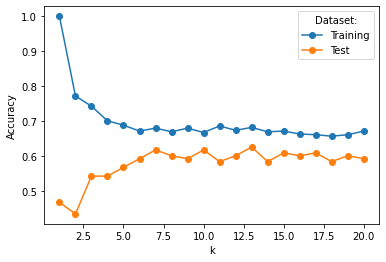

In [29]:
# Answer to exercise 9

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_mc["Race"]

k_vals = list(range(1, 21))
train_acc = [] #collect values for train accuracy
test_acc = [] #collect values for test accuracy

#We use a fixed split between training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
for k in k_vals:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train, y_train)
    train_acc.append(knn_model.score(X_train, y_train))
    test_acc.append(knn_model.score(X_test, y_test))

#Plotting can be done in different ways. This is one way
plt.plot(k_vals, train_acc, 'o-', label = "Training")
plt.plot(k_vals, test_acc, 'o-', label = "Test")
plt.legend(title='Dataset:')
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.show()

#You see a perfect prediction on the training set for k = 1 and poor generalisation on the test set, suggestive of overfitting.


Bias-variance decomposition can be performed with the mlxtend package.

You might need to install it first (use pip install mlxtend).

It only seems to work for a two-class classification problem and it seems to require the target variable to be coded as 0/1 (but let me know if you find out how to use it on more than 2 classes). 

The following code estimates the variance and bias for one value of k.

In [30]:
from mlxtend.evaluate import bias_variance_decomp
import numpy as np

for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
for_mc = for_mc[(for_mc["Race"] == "W") | (for_mc["Race"] == "B")]
for_mc["race_bin"] = np.where(for_mc["Race"] == "W", 1, 0)
X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_mc["race_bin"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def calculate_bias_variance(k, train_X, train_y, test_X, test_y):
    model = KNeighborsClassifier(n_neighbors=k)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model,
        train_X.values,  
        train_y.values,  
        test_X.values,   
        test_y.values,   
        loss='0-1_loss',
        num_rounds=10,
        random_seed=42
    )
    return avg_bias, avg_var, avg_expected_loss


bias, variance, expected_loss = calculate_bias_variance(3, X_train, y_train, X_test, y_test)

print("Bias:", bias)
print("Variance:", variance)

Bias: 0.09210526315789473
Variance: 0.07631578947368421


# Exercise 10

- Compute the variance and bias for values of k ranging from 1 to 21 and plot these values as a function of k.
- Try a few values for the random state for splitting the data into a training and a test set.

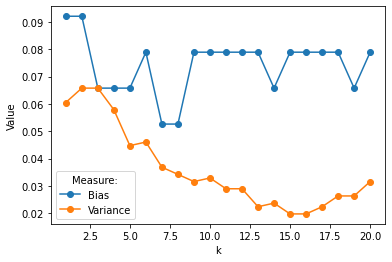

In [31]:
#Answer Exercise 10


from mlxtend.evaluate import bias_variance_decomp
import numpy as np

for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
for_mc = for_mc[(for_mc["Race"] == "W") | (for_mc["Race"] == "B")]
for_mc["race_bin"] = np.where(for_mc["Race"] == "W", 1, 0)
X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_mc["race_bin"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def calculate_bias_variance(k, train_X, train_y, test_X, test_y):
    model = KNeighborsClassifier(n_neighbors=k)
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        model,
        train_X.values,  
        train_y.values,  
        test_X.values,   
        test_y.values,   
        loss='0-1_loss',
        num_rounds=10,
        random_seed=42
    )
    return avg_bias, avg_var, avg_expected_loss

k_vals = list(range(1, 21))
bias_vals = [] #collect values for bias
variance_vals = [] #collect values for variance


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 10)
for k in k_vals:
    bias, variance, expected_loss = calculate_bias_variance(k, X_train, y_train, X_test, y_test)
    bias_vals.append(bias)
    variance_vals.append(variance)

#Plotting can be done in different ways. This is one way
plt.plot(k_vals, bias_vals, 'o-', label = "Bias")
plt.plot(k_vals, variance_vals, 'o-', label = "Variance")
plt.legend(title='Measure:')
plt.xlabel("k")
plt.ylabel("Value")
plt.show()

# Model dimensions: Model, loss-function, optimizer

For each model, we have the following dimensions:
- The model
- The loss function
- The optimizer

We here only explore the loss function (to avoid an extremely long notebook).

The default loss function for the logistic regression in sklearn includes an L2 term. 

![alt text](penalty.png "Penalty logistic regression in sklearn")

    

## Exercise 11

Examine the effect of using the L1, "None", and "elasticnet" penalties for the prediction of race from nose width, nose length, lip thickness and face length.


- for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
- X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
- y = for_mc["Race"]

Split the data in training and test (80%-20%) with a random state of 42, and compute the accuracy on the training and the test set. Always use the saga optimizer. For the elastic net, set the l1_ratio to 0.2.

In [32]:
#Answer Exercise 11
for_mc = faces[["Race", "Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
X = for_mc[["Nose_Width", "Nose_Length","Lip_Thickness","Face_Length"]]
y = for_mc["Race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

lr_model = LogisticRegression(penalty = "l2", solver = "saga")
lr_model.fit(X_train, y_train)
train_acc_lr = lr_model.score(X_train, y_train)
test_acc_lr = lr_model.score(X_test, y_test)
print("Accuracy train/test LR standard:", train_acc_lr, test_acc_lr)


l1_model = LogisticRegression(penalty = "l1", solver = "saga")
l1_model.fit(X_train, y_train)
train_acc_l1 = l1_model.score(X_train, y_train)
test_acc_l1 = l1_model.score(X_test, y_test)
print("Accuracy train/test LR L1:", train_acc_l1, test_acc_l1)


none_model = LogisticRegression(penalty = "none", solver = "saga")
none_model.fit(X_train, y_train)
train_acc_none = none_model.score(X_train, y_train)
test_acc_none = none_model.score(X_test, y_test)
print("Accuracy train/test LR none:", train_acc_none, test_acc_none)

el_model = LogisticRegression(penalty = "elasticnet", solver = "saga", l1_ratio = 0.2)
el_model.fit(X_train, y_train)
train_acc_el = el_model.score(X_train, y_train)
test_acc_el = el_model.score(X_test, y_test)
print("Accuracy train/test LR elastic:", train_acc_el, test_acc_el)


Accuracy train/test LR standard: 0.6121593291404612 0.6083333333333333
Accuracy train/test LR L1: 0.6121593291404612 0.6


/home/frouke/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/frouke/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


InvalidParameterError: The 'penalty' parameter of LogisticRegression must be a str among {'l1', 'elasticnet', 'l2'} or None. Got 'none' instead.

# Mahalanobis distance

Another concept from the learning unit is the mahalanobis distance.

This exercise was inspired by https://medium.com/@the_daft_introvert/mahalanobis-distance-5c11a757b099.
    
The mahalanobis distance is computed between a point and a set of points. It can be used to detect outliers in data.

We will use the features:
* Face_Length
* Lip_Thickness

We here use only two features, because this makes it easier to plot the data.

## Exercise 12

Create a scatterplot of the Face Length and Lip Thickness with Seaborn scatterplot.

In [ ]:
#Answer Exercise 12
import seaborn as sns #for nicer looking plots

sns.scatterplot(data=faces, x="Face_Length", y="Lip_Thickness")

For the Mahalanobis distance, we first need to compute the mean vector and covariance matrix across all dots except the dot for which we want to compute the distance.

Before computing the mean with the code below, try to guess how long the mean vector will be.

In [ ]:
import numpy as np
from scipy.spatial.distance import mahalanobis

row_number = 1

remainder = faces.drop(row_number)[["Target", "Face_Length", "Lip_Thickness"]]
selected = faces.iloc[row_number][["Target", "Face_Length", "Lip_Thickness"]]

print(remainder.head()) #to check that the correct line has been dropped
print(selected)

mu = np.mean(remainder[["Face_Length", "Lip_Thickness"]], axis=0)
sigma = np.cov(remainder[["Face_Length", "Lip_Thickness"]].T)
print(mu)

Now we can compute the distance between the target row and the remainder of the rows.

In [ ]:
mah_dist = mahalanobis(selected[["Face_Length", "Lip_Thickness"]], mu, np.linalg.inv(sigma))
print(mah_dist)

## Exercise 13

Now create a loop and compute the Mahalanobis for each point in the data to the remaining points. Add the distances to the data-frame.

In [ ]:
#Answer Exercise 13
def compute_distance(row_number,df, col1, col2):

    remainder = df.drop(row_number)[[col1, col2]]
    selected = df.iloc[row_number][[col1, col2]]

    mu = np.mean(remainder, axis=0)
    sigma = np.cov(remainder.T)
    dist = mahalanobis(selected, mu, np.linalg.inv(sigma))
    
    return(dist)

distances = []
for row_number in range(faces.shape[0]):
    dist = compute_distance(row_number, faces, "Face_Length", "Lip_Thickness")
    distances.append(dist)
    
faces["mah_dist"] = distances

faces[["Target", "Face_Length", "Lip_Thickness", "mah_dist"]].head()

## Exercise 14

Now create the scatterplot where you color the dots according to the distance that you just computed.

Is it clear what the distance represents from the plot?



In [ ]:
#Answer Exercise 14
sns.scatterplot(data=faces, x="Face_Length", y="Lip_Thickness", hue = "mah_dist")

# Linear discrimination: LDA

A further classifier described in the chapter is the linear discriminant analysis (LDA).

The documentation says the following about this classifier:
    
- A classifier with a linear decision boundary, generated by fitting class conditional densities to the data and using Bayes’ rule.

- The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix.

- The fitted model can also be used to reduce the dimensionality of the input by projecting it to the most discriminative directions, using the transform method.    

From: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

We here examine how to apply the LDA classifier, and compare it to the logistic regression model.

## Exercise 15

Look up the documentation of the LDA and apply the model to the race classification problem:
    
- for_mc = faces[["Race", "Nose_Width", "Lip_Thickness"]]
- X = for_mc[["Nose_Width", "Lip_Thickness"]]
- y = for_mc["Race"]    
    
Split the data in training and test (80%-20%) with a random state of 42, and compute the accuracy on the training and the test set.     

Compare the accuracy to that of the standard logistic regression.

In [ ]:
#Answer Exercise 15
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

for_mc = faces[["Race", "Nose_Width", "Lip_Thickness"]]
X = for_mc[["Nose_Width", "Lip_Thickness"]]
y = for_mc["Race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
train_acc_lr = lr_model.score(X_train, y_train)
test_acc_lr = lr_model.score(X_test, y_test)
print("Accuracy train/test LR standard:", train_acc_lr, test_acc_lr)

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
train_acc_lda = lda_model.score(X_train, y_train)
test_acc_lda = lda_model.score(X_test, y_test)
print("Accuracy train/test LR standard:", train_acc_lda, test_acc_lda)


## Exercise 16

We can use the mlxtend package to examine how the models separate the feature space.

Use:

- from mlxtend.plotting import plot_decision_regions
- plot_decision_regions(X_test, y_test, clf=<name classifier>, legend=2)
- plt.show()

to compare the separation of feature space of the LDA and the logistic regression.
    
You might need to install the package first and you might need to convert some of the input to a different format.

In [ ]:
#Answer exercise 16
from mlxtend.plotting import plot_decision_regions

for_mc = faces[["Race", "Nose_Width", "Lip_Thickness"]]
for_mc["Race"].replace(["A", "B", "L", "W"],
                        [0, 1, 2, 3], inplace=True)
X = for_mc[["Nose_Width", "Lip_Thickness"]]
y = for_mc["Race"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

plot_decision_regions(X_test.values, y_test.values, clf=lr_model, legend=2)


In [ ]:
#Answer Exercise 16b
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

plot_decision_regions(X_test.values, y_test.values, clf=lda_model, legend=2)

# Regression and logistic regression

We have used the logistic regression a few times now. In this final section, we explore the rationale between the two techniques. We use the case of a single feature / predictor variable, because it helps plotting the data.

For regression, we will look at the estimated age of the person in the image.

## Exercise 17

- Plot the histogram of the age column in the dataset. Is age approximately normally distributed?
- Plot the histogram of the age column per race (you can use subplots or a density plot).
- Plot the histogram of trustworthiness

In [ ]:
#Exercise 17
sns.histplot(data=faces, x="Age")

In [ ]:
#Exercise 17b
g = sns.FacetGrid(faces, col="Race", col_wrap=2, sharex=False)
g.map(plt.hist, "Age")

In [ ]:
#Exercise 17c

sns.histplot(faces, x = "Trustworthy")

## Exercise 18

We can now examine whether older people are rated as more trustworthy.

Create a scatterplot where you place age on the horizontal axis and trustworthiness rating on the vertical axis. Draw the best fitting regression line in the plot. Does the regression line suggest that older people are rated as more trustworthy?


In [ ]:
# Exercise 18

sns.regplot(data=faces, x="Age", y="Trustworthy")

#The reverse seems to be true: Older -> less trustworthy

## Exercise 19

- Split the data in training (80%) and test (20%)
- Fit a regression model predicting trustworthiness from age on the training set
- Compute the performance on the training and test set
- Do these indicate a good fit?
- Determine the regression coefficients
- How do these relate to the regression line in the plot?

In [ ]:
# Exercise 19
from sklearn.linear_model import LinearRegression

X = faces[["Age"]]
y = faces["Trustworthy"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

print("On training set:", reg_model.score(X_train, y_train)) #values close to 1 indicate good performance
print("On test set:", reg_model.score(X_test, y_test)) #values close to 0 indicate poor performance
#These scores indicate poor prediction

print("Slope:", reg_model.coef_) #slope of the line
print("Intercept:", reg_model.intercept_) # intersection line with y-axis




## Exercise 20

We have already used the logistic regression in previous exercises. We here only look at how to visualise what the logistic regression does.

- Convert the variable "Gender" to a 1 for female and 0 for male faces
- Create a plot with the variable "Feminine" on the x-axis and the binary variable that you just made on the vertical axis
- Add the regression line to the plot


<AxesSubplot:xlabel='Feminine', ylabel='gender_bin'>

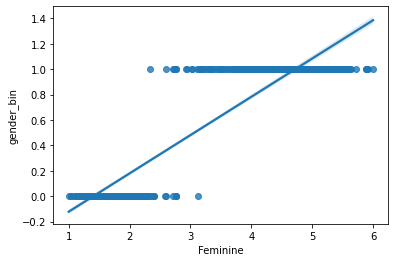

In [33]:
#Exercise 20

faces["gender_bin"] = np.where(faces["Gender"] == "F", 1, 0)
sns.regplot(data=faces, x="Feminine", y = "gender_bin")


## Exercise 21

The regression line does not make much sense for binary data.

- Use the regplot from seaborn, but not with the "logistic" argument set to True

You may need to install the statmodels package.

Does the fit make more sense now?


/home/frouke/.local/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


<AxesSubplot:xlabel='Feminine', ylabel='gender_bin'>

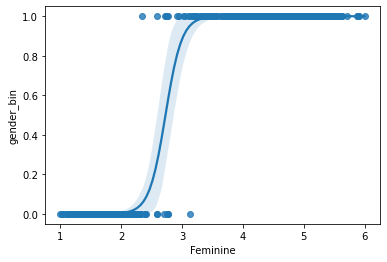

In [34]:
# With statsmodels show an s-shaped curve through the data. This is how the logistic regression links the predictor variable to the binary target variable.
sns.regplot(data=faces, x="Feminine", y = "gender_bin", logistic = True)
